# A/B тест

В данном проект я проведу А/В тестирование по данным: https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing/data

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.stats.api as sms
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Кирилл/Desktop/Аналитик данных/ПЭТ проекты/A-B test 2/cookie_cats.csv')

In [3]:
# Функция проверки качества данных
def initial_inspection(df):
    
    print("=== ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ ===")
    
    # Первые 5 строк
    print("\n1. Первые 5 строк данных:")
    print(df.head())
    
    # Информация о данных
    print("\n2. Информация о структуре данных:")
    print(df.info())
    
    # Описательная статистика
    print("\n3. Описательная статистика:")
    print(df.describe())
    
    # Проверка на пропуски
    print("\n4. Проверка на пропущенные значения:")
    missing_values = df.isnull().sum()
    print(missing_values)
    
    return df

In [4]:
initial_inspection(df)

=== ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ ===

1. Первые 5 строк данных:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

2. Информация о структуре данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None

3. Описательная статистика:
             userid  sum_gamero

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


В датасете представлены следующие данные:
 - userid: id пользователя;
 - version: версия шлюза;
 - sum_gamerounds: количество пройденных уровней;
 - retention_1: удержание на 1-ый день;
 - retention_7: удержание на 7-ый день.

Пропущенные значения отсутствуют.

In [5]:
# Должны быть только две группы: gate_30 и gate_40
print("Уникальные группы:", df['version'].unique())

Уникальные группы: ['gate_30' 'gate_40']


## Проверка на дубликаты

In [6]:
print(f"Есть ли дубликаты userid? {df['userid'].duplicated().any()}")

Есть ли дубликаты userid? False


Дубликаты отсутствуют

## Проверка на выбросы

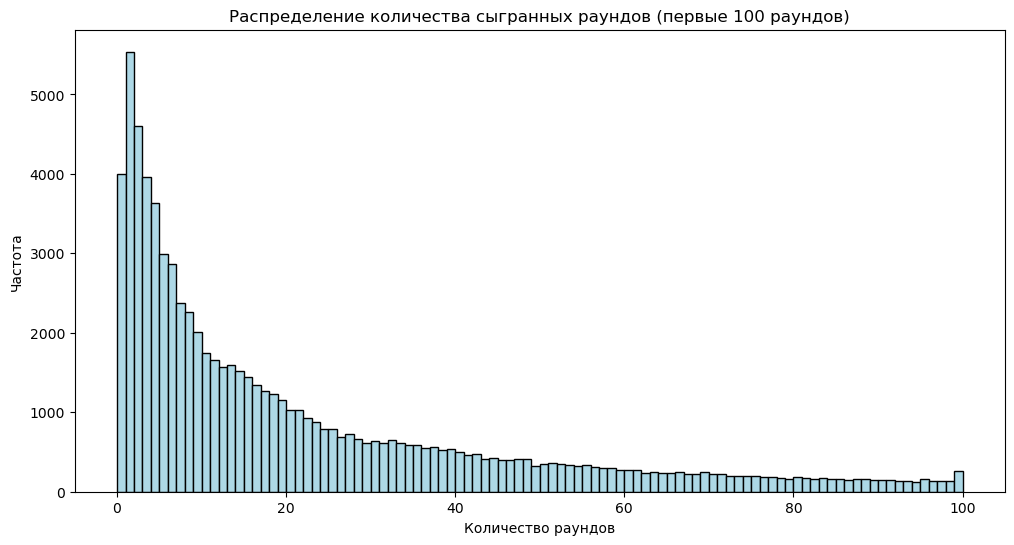

Максимальное значение раундов: 49854
Количество игроков, сыгравших > 1000 раундов: 116
Количество игроков, сыгравших 0 раундов: 3994


In [7]:
# Посмотрим на распределение игровых раундов
plt.figure(figsize=(12,6))
plt.hist(df['sum_gamerounds'], bins=100, range=(0, 100), color='lightblue', edgecolor='black')
plt.title('Распределение количества сыгранных раундов (первые 100 раундов)')
plt.xlabel('Количество раундов')
plt.ylabel('Частота')
plt.show()

# Посмотрим на игроков с аномально высоким количеством раундов
print(f"Максимальное значение раундов: {df['sum_gamerounds'].max()}")
print(f"Количество игроков, сыгравших > 1000 раундов: {(df['sum_gamerounds'] > 1000).sum()}")
print(f"Количество игроков, сыгравших 0 раундов: {(df['sum_gamerounds'] == 0).sum()}")

Игроков, сыгравших 0 раундов, 3994 шт. Данных игроков мы удалим из анализа, так как они не взаимодействовали с продуктом.
Игроков с огромным количеством сыгранных раундов удалять не будем.

In [8]:
# Сохраняем размер до очистки
print(f"Размер до очистки: {df.shape}")

# Удаляем пользователей, которые не сыграли ни одного раунда
df = df[df['sum_gamerounds'] > 0]

print(f"Размер после очистки: {df.shape}")

Размер до очистки: (90189, 5)
Размер после очистки: (86195, 5)


## Разведочный анализ (EDA)

In [9]:
# Считаем количество игроков в каждой группе
group_stats = df['version'].value_counts().reset_index()
group_stats.columns = ['version', 'count']
print(group_stats)

   version  count
0  gate_40  43432
1  gate_30  42763


In [10]:
# Посчитаем количество пользователей в каждой группе
group_counts = df['version'].value_counts()
print("Распределение по группам:")
print(group_counts)

# В идеале соотношение должно быть близко к 50/50
print(f"\nСоотношение: {group_counts['gate_40']/group_counts.sum():.3f} : {group_counts['gate_30']/group_counts.sum():.3f}")

# Проверим статистическую значимость различия в размерах групп (Xи-квадрат)
# Нулевая гипотеза (H₀): Распределение наблюдений по группам является равномерным (т.е., размеры всех групп статистически не отличаются)
# Альтернативная гипотеза (H₁): Распределение не является равномерным (размеры групп статистически значимо различаются)
chi2, p_value, _, _ = chi2_contingency([group_counts.values])
print(f"p-value для проверки равномерности распределения: {p_value:.4f}")

Распределение по группам:
version
gate_40    43432
gate_30    42763
Name: count, dtype: int64

Соотношение: 0.504 : 0.496
p-value для проверки равномерности распределения: 1.0000


Группы примерно одинакового размера.
Нулевую гипотезу не можем отвергнуть. Группы распределены равномерно.

              mean  median         std  count
version                                      
gate_30  54.832332    18.0  262.217984  42763
gate_40  53.728357    18.0  105.093012  43432


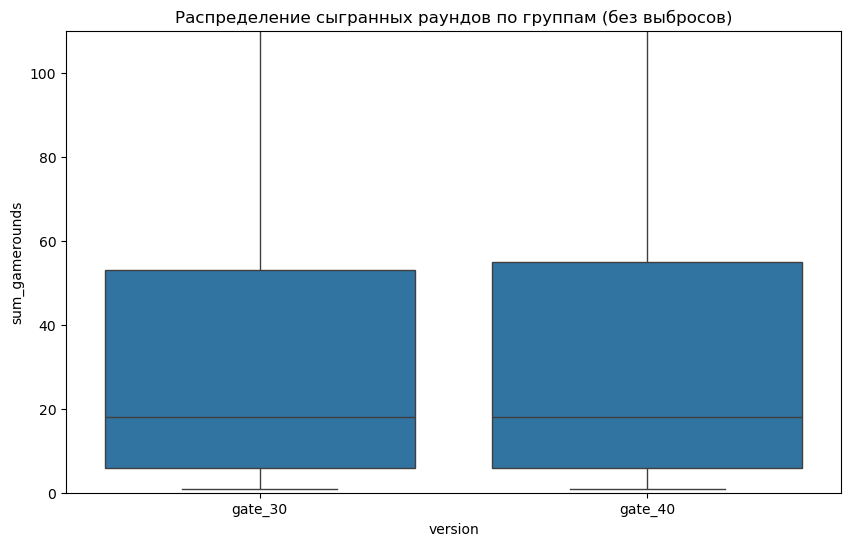

In [11]:
# Сравним медиану и среднее по группам
print(df.groupby('version')['sum_gamerounds'].agg(['mean', 'median', 'std', 'count']))

# Построим boxplot для визуализации распределения (ограничим по оси Y для наглядности)
plt.figure(figsize=(10,6))
sns.boxplot(x='version', y='sum_gamerounds', data=df, showfliers=False) # showfliers=False убирает выбросы для наглядности
plt.title('Распределение сыгранных раундов по группам (без выбросов)')
plt.ylim(0, 110)
plt.show()

Группы выглядят сопоставимо по количеству раундов.

# A/B тест

Сформулируем гипотезы:

    H0: Доли удержания (retention_1 и retention_7) в группе gate_30 и gate_40 одинаковы.
    H1: Доли удержания различаются.

In [12]:
# Функция для проведения Z-теста для двух пропорций
def proportional_z_test(x1, n1, x2, n2, alpha=0.05):
    """
    Проводит Z-тест для двух пропорций и возвращает p-value и доверительный интервал
    """
    # Вычисляем пропорции
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    
    # Вычисляем стандартную ошибку
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    
    # Вычисляем Z-статистику
    z_stat = (p1 - p2) / se
    
    # Вычисляем p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    # Вычисляем доверительный интервал
    margin_of_error = stats.norm.ppf(1 - alpha/2) * se
    ci_low = (p1 - p2) - margin_of_error
    ci_high = (p1 - p2) + margin_of_error
    
    return z_stat, p_value, (ci_low, ci_high), (p1, p2)

In [13]:
# Создаем датафреймы для каждой группы
group_30 = df[df['version'] == 'gate_30']
group_40 = df[df['version'] == 'gate_40']

In [14]:
# Проводим тест для retention_1
n1 = len(group_30)
n2 = len(group_40)
x1 = group_30['retention_1'].sum()  # Количество удержанных в группе gate_30
x2 = group_40['retention_1'].sum()  # Количество удержанных в группе gate_40

z_stat_1, p_value_1, ci_1, proportions_1 = proportional_z_test(x1, n1, x2, n2)

In [15]:
# Проводим тест для retention_7
x1_7 = group_30['retention_7'].sum()
x2_7 = group_40['retention_7'].sum()

z_stat_7, p_value_7, ci_7, proportions_7 = proportional_z_test(x1_7, n1, x2_7, n2)

In [16]:
proportions_1

(0.46753034165049223, 0.46217074967765703)

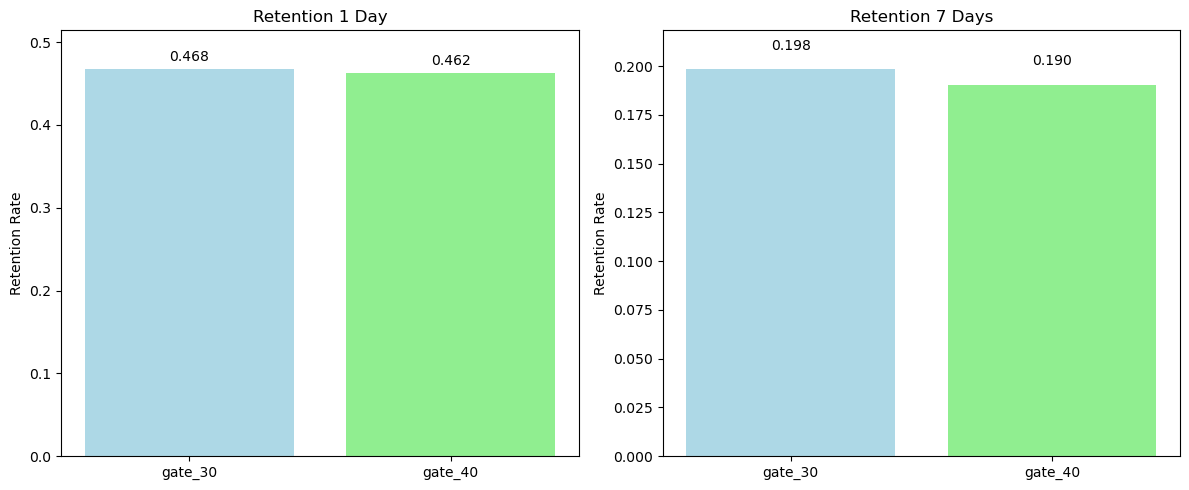

In [17]:
# Визуализация результатов
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# График для retention_1
retention_data_1 = {
    'gate_30': proportions_1[0],
    'gate_40': proportions_1[1]
}
ax[0].bar(retention_data_1.keys(), retention_data_1.values(), color=['lightblue', 'lightgreen'])
ax[0].set_title('Retention 1 Day')
ax[0].set_ylabel('Retention Rate')
ax[0].set_ylim(0, max(retention_data_1.values()) * 1.1)
for i, v in enumerate(retention_data_1.values()):
    ax[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# График для retention_7
retention_data_7 = {
    'gate_30': proportions_7[0],
    'gate_40': proportions_7[1]
}
ax[1].bar(retention_data_7.keys(), retention_data_7.values(), color=['lightblue', 'lightgreen'])
ax[1].set_title('Retention 7 Days')
ax[1].set_ylabel('Retention Rate')
ax[1].set_ylim(0, max(retention_data_7.values()) * 1.1)
for i, v in enumerate(retention_data_7.values()):
    ax[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [18]:
# Выводим результаты тестов
print("Результаты A/B теста для Retention 1 Day:")
print(f"Группа gate_30: {proportions_1[0]:.4f} ({x1}/{n1})")
print(f"Группа gate_40: {proportions_1[1]:.4f} ({x2}/{n2})")
print(f"Разница: {proportions_1[0] - proportions_1[1]:.4f}")
print(f"95% доверительный интервал: [{ci_1[0]:.4f}, {ci_1[1]:.4f}]")
print(f"Z-статистика: {z_stat_1:.4f}, p-value: {p_value_1:.4f}")
if p_value_1 < 0.05:
    print("Статистически значимая разница обнаружена (p < 0.05)")
else:
    print("Статистически значимой разницы не обнаружено (p >= 0.05)")
print()

print("Результаты A/B теста для Retention 7 Days:")
print(f"Группа gate_30: {proportions_7[0]:.4f} ({x1_7}/{n1})")
print(f"Группа gate_40: {proportions_7[1]:.4f} ({x2_7}/{n2})")
print(f"Разница: {proportions_7[0] - proportions_7[1]:.4f}")
print(f"95% доверительный интервал: [{ci_7[0]:.4f}, {ci_7[1]:.4f}]")
print(f"Z-статистика: {z_stat_7:.4f}, p-value: {p_value_7:.4f}")
if p_value_7 < 0.05:
    print("Статистически значимая разница обнаружена (p < 0.05)")
else:
    print("Статистически значимой разницы не обнаружено (p >= 0.05)")

Результаты A/B теста для Retention 1 Day:
Группа gate_30: 0.4675 (19993/42763)
Группа gate_40: 0.4622 (20073/43432)
Разница: 0.0054
95% доверительный интервал: [-0.0013, 0.0120]
Z-статистика: 1.5774, p-value: 0.1147
Статистически значимой разницы не обнаружено (p >= 0.05)

Результаты A/B теста для Retention 7 Days:
Группа gate_30: 0.1984 (8486/42763)
Группа gate_40: 0.1903 (8266/43432)
Разница: 0.0081
95% доверительный интервал: [0.0028, 0.0134]
Z-статистика: 3.0130, p-value: 0.0026
Статистически значимая разница обнаружена (p < 0.05)


Конверсия в 1-ый день не показывает статистически значимой разницы между группами, то есть эффекта нет. Только конверсия на 7-й день показывает, что статистически значимая разница обнаружена.